In [1]:
import os
import numpy as np
import pandas as pd
from tqdm import tqdm
import matplotlib.pyplot as plt

In [2]:
output_dir = 'outputs'
os.makedirs(output_dir, exist_ok=True)

In [3]:
csv_dir = '/ccn2/dataset/babyview/outputs_20250312/activities/videollama3_constrained'
csv_files = [f for f in os.listdir(csv_dir) if f.endswith('.csv')]
print(f'Found {len(csv_files)} CSV files in {csv_dir}')

Found 4666 CSV files in /ccn2/dataset/babyview/outputs_20250312/activities/videollama3_constrained


In [4]:
# Read and concatenate all CSV files into a single DataFrame, then extract the Location and Activity series.
dfs = []
non_bing_counts = 0
for csv_file in tqdm(csv_files, desc="Processing CSV files"):
    # Skip Bing files
    if csv_file.startswith('01') or csv_file.startswith('02'):
        continue
    non_bing_counts += 1
    file_path = os.path.join(csv_dir, csv_file)
    df = pd.read_csv(file_path)
    # Only include files with both columns
    if 'Location' in df.columns and 'Activity' in df.columns:
        dfs.append(df)
        
big_df = pd.concat(dfs, ignore_index=True)
print('Non-Bing CSV files:', non_bing_counts)
print(f'Combined DataFrame has {len(big_df)} rows.')

# Extract and convert to strings
location_series = big_df['Location'].astype(str)
activity_series = big_df['Activity'].astype(str)

Processing CSV files:   0%|          | 0/4666 [00:00<?, ?it/s]

Processing CSV files: 100%|██████████| 4666/4666 [00:13<00:00, 346.38it/s]


Non-Bing CSV files: 4666
Combined DataFrame has 318521 rows.


## Separately: Locations, Activities

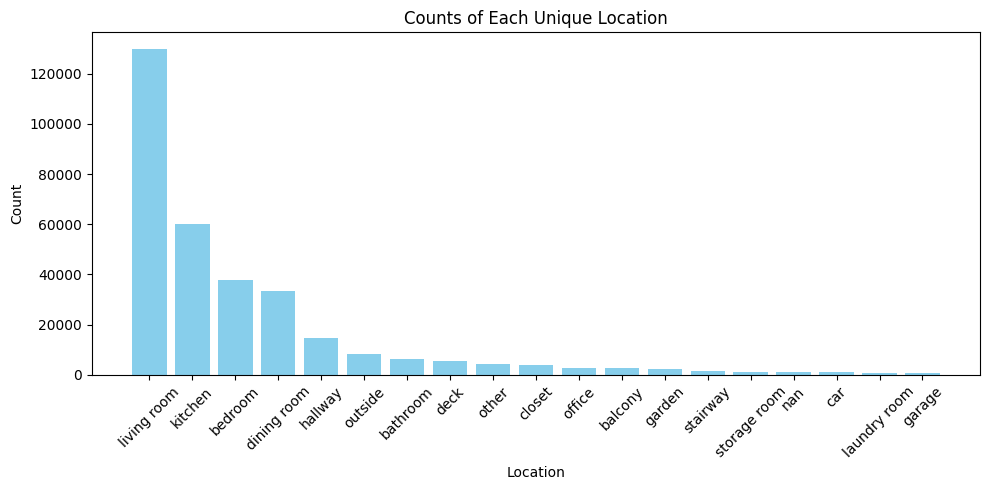

In [5]:
location_counts = location_series.value_counts()
plt.figure(figsize=(10, 5))
plt.bar(location_counts.index, location_counts.values, color='skyblue')
plt.xticks(rotation=45)
plt.xlabel("Location")
plt.ylabel("Count")
plt.title("Counts of Each Unique Location")
plt.tight_layout()
plt.show()

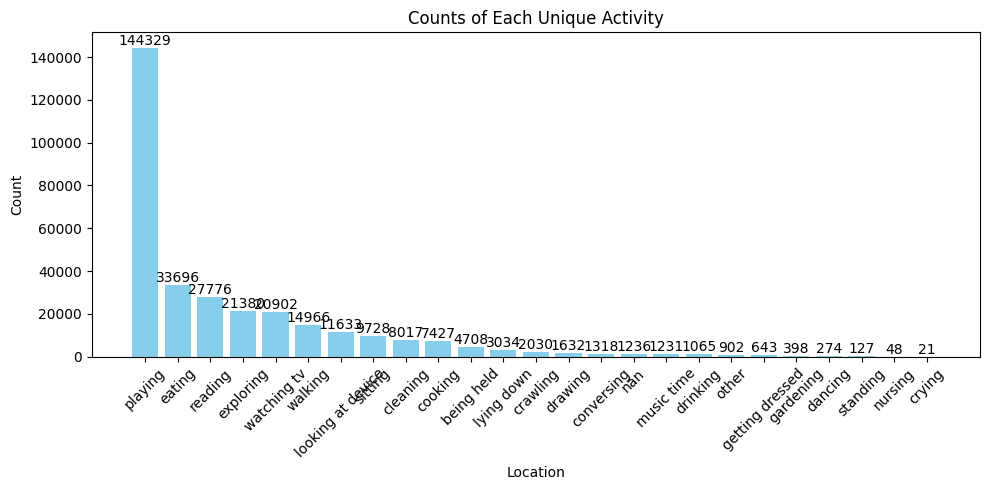

In [6]:
activity_counts = activity_series.value_counts()
plt.figure(figsize=(10, 5))
plt.bar(activity_counts.index, activity_counts.values, color='skyblue')
plt.xticks(rotation=45)
plt.xlabel("Location")
plt.ylabel("Count")
plt.title("Counts of Each Unique Activity")
plt.tight_layout()
for bar in plt.gca().patches:
    plt.text(
        bar.get_x() + bar.get_width() / 2,
        bar.get_height(),
        int(bar.get_height()),
        ha="center",
        va="bottom"
    )
plt.show()

# Locations + Activities

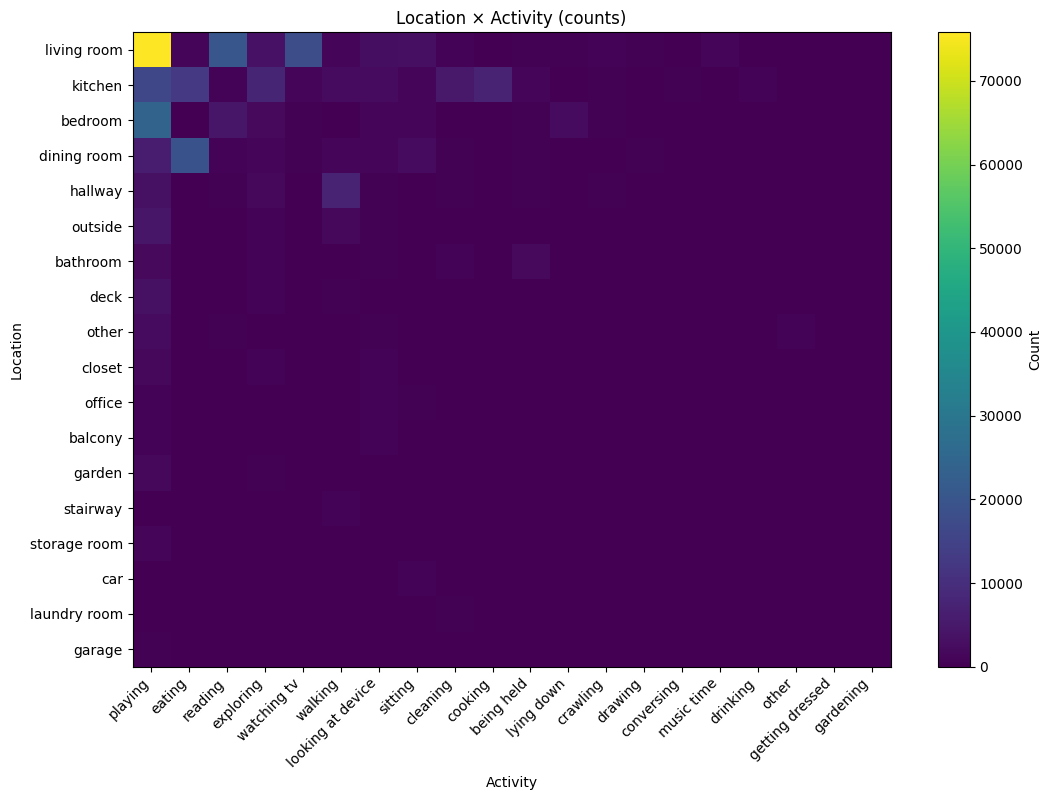

In [7]:
df = big_df.copy()
df = df.dropna(subset=["Location", "Activity"])
for col in ["Location", "Activity"]:
    df[col] = df[col].astype(str).str.strip().fillna("Unknown")

# contingency table
ct = pd.crosstab(df["Location"], df["Activity"])

# (optional) keep top-N by totals so the plot is readable
top_rows = ct.sum(1).nlargest(20).index
top_cols = ct.sum(0).nlargest(20).index
ct = ct.loc[top_rows, top_cols]

fig, ax = plt.subplots(figsize=(max(8, 0.55*len(ct.columns)), max(6, 0.45*len(ct))))
im = ax.imshow(ct.values, aspect="auto")
ax.set_xticks(np.arange(ct.shape[1])); ax.set_xticklabels(ct.columns, rotation=45, ha="right")
ax.set_yticks(np.arange(ct.shape[0])); ax.set_yticklabels(ct.index)
ax.set_xlabel("Activity"); ax.set_ylabel("Location"); ax.set_title("Location × Activity (counts)")
plt.colorbar(im, ax=ax, label="Count")
plt.tight_layout()

### 2) Row-normalized (“distribution of activities within each location”)

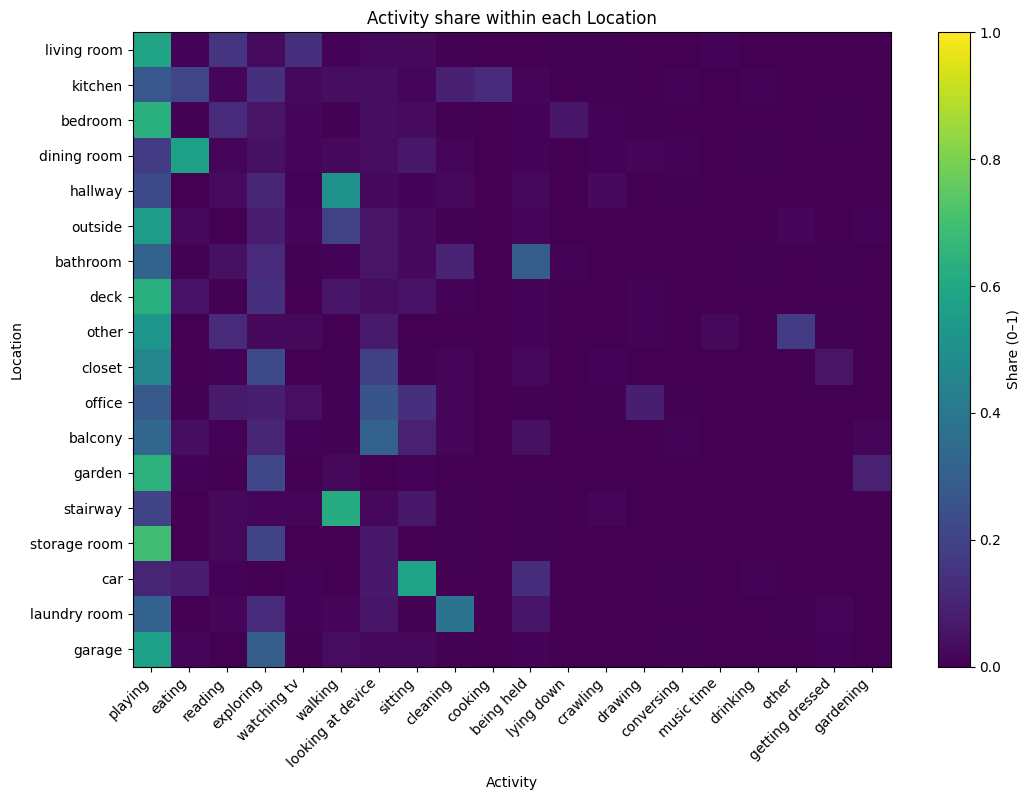

In [8]:
row_share = ct.div(ct.sum(1).replace(0, 1), axis=0)

fig, ax = plt.subplots(figsize=(max(8, 0.55*len(row_share.columns)), max(6, 0.45*len(row_share))))
im = ax.imshow(row_share.values, aspect="auto", vmin=0, vmax=1)
ax.set_xticks(np.arange(row_share.shape[1])); ax.set_xticklabels(row_share.columns, rotation=45, ha="right")
ax.set_yticks(np.arange(row_share.shape[0])); ax.set_yticklabels(row_share.index)
ax.set_xlabel("Activity"); ax.set_ylabel("Location"); ax.set_title("Activity share within each Location")
plt.colorbar(im, ax=ax, label="Share (0–1)")
plt.tight_layout()


### 3) “Surprise” map (which pairs are over/under-represented given totals)

This controls for marginals and highlights associations, not just frequency.

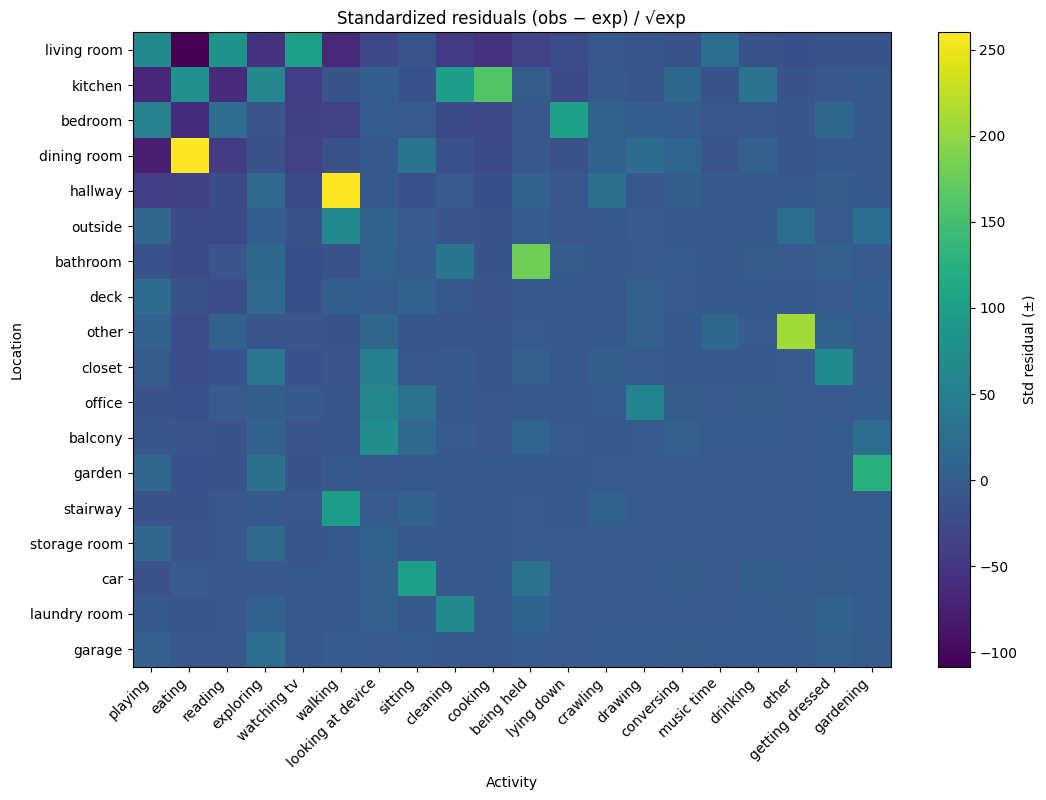

In [9]:
import numpy as np

obs = ct.values
row_tot = obs.sum(axis=1, keepdims=True)
col_tot = obs.sum(axis=0, keepdims=True)
grand = obs.sum()
expected = row_tot @ col_tot / grand
std_resid = (obs - expected) / np.sqrt(np.maximum(expected, 1e-9))

fig, ax = plt.subplots(figsize=(max(8, 0.55*ct.shape[1]), max(6, 0.45*ct.shape[0])))
im = ax.imshow(std_resid, aspect="auto")
ax.set_xticks(np.arange(ct.shape[1])); ax.set_xticklabels(ct.columns, rotation=45, ha="right")
ax.set_yticks(np.arange(ct.shape[0])); ax.set_yticklabels(ct.index)
ax.set_xlabel("Activity"); ax.set_ylabel("Location"); ax.set_title("Standardized residuals (obs − exp) / √exp")
plt.colorbar(im, ax=ax, label="Std residual (±)")
plt.tight_layout()


### 4) Alternative view (stacked bars)

Good when you have many activities but want per-location distributions.

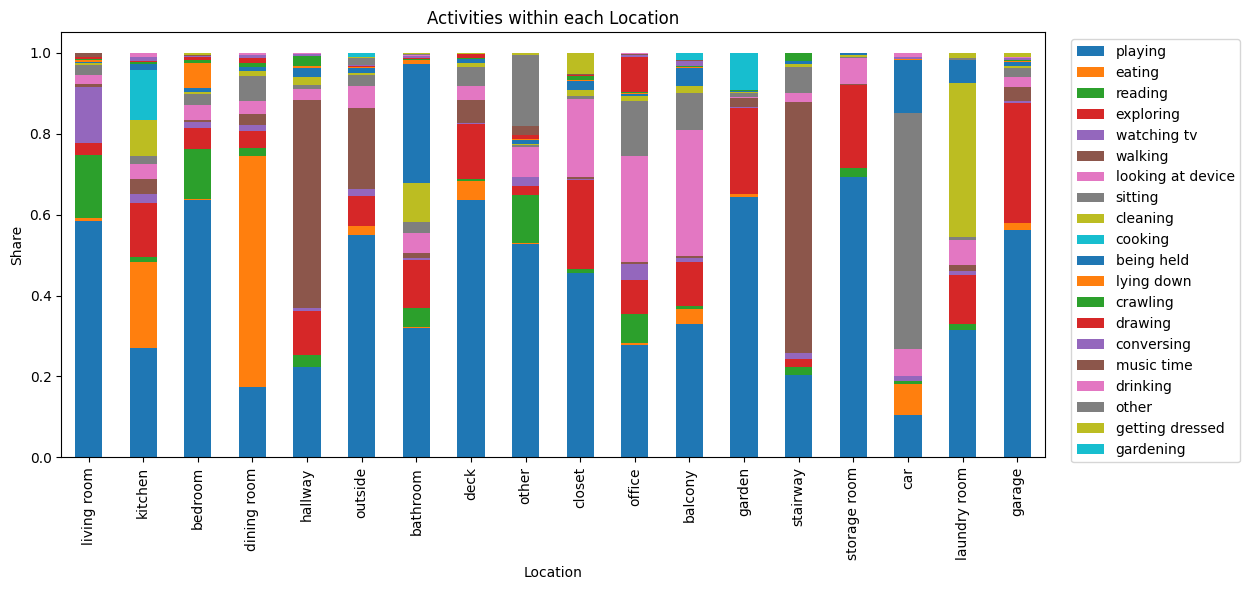

In [10]:
row_share.plot(kind="bar", stacked=True, figsize=(max(8, 0.7*len(row_share)), 6))
plt.ylabel("Share"); plt.title("Activities within each Location")
plt.legend(bbox_to_anchor=(1.02, 1), loc="upper left"); plt.tight_layout()


## IMU + (Locations, Activities)

In [11]:
overall_imu_dir = '/ccn2/dataset/babyview/outputs_20250312/imu/10s_clips/'
imu_csv_files = [f for f in os.listdir(overall_imu_dir) if f.endswith('.csv')]

dfs_imu = []
for f in tqdm(imu_csv_files, desc="Processing IMU CSV files"):
    df_imu = pd.read_csv(os.path.join(overall_imu_dir, f))
    dfs_imu.append(df_imu)
imu_df = pd.concat(dfs_imu, ignore_index=True)
print(f"Concatenated {len(imu_csv_files)} files into a DataFrame with {len(imu_df)} rows.")

Processing IMU CSV files:   1%|          | 36/5367 [00:00<00:15, 349.20it/s]

Processing IMU CSV files: 100%|██████████| 5367/5367 [00:14<00:00, 366.17it/s]


Concatenated 5367 files into a DataFrame with 356461 rows.


In [12]:
# merge big_df with imu_df on video_id, big_df should have the main key,
# and drop the imu rows which did not match
merged_df = big_df.merge(imu_df, on="video_id", how="inner", suffixes=("", "_imu"))
print('Merged DataFrame has', len(merged_df), 'rows after inner join on video_id.')

merged_df = merged_df.dropna(how="any")
print('Merged DataFrame has', len(merged_df), 'rows after dropping rows with any NaN values.')

Merged DataFrame has 314789 rows after inner join on video_id.
Merged DataFrame has 313656 rows after dropping rows with any NaN values.


In [13]:
import numpy as np
import pandas as pd

df = merged_df.copy()

acc_cols  = ["ACCL_X (m/s²)","ACCL_Y (m/s²)","ACCL_Z (m/s²)"]
grav_cols = ["GRAV_X (m/s²)","GRAV_Y (m/s²)","GRAV_Z (m/s²)"]

df[acc_cols+grav_cols] = df[acc_cols+grav_cols].apply(pd.to_numeric, errors="coerce")

A = df[acc_cols].to_numpy()
G = df[grav_cols].to_numpy()

# Detect GRAV_* scale (≈1 or ≈9.81). Your screenshot suggests ≈1.
g_norm = np.nanmedian(np.linalg.norm(G, axis=1))
if 0.5 < g_norm < 2:        # GRAV_* is ~unit vector: scale to m/s²
    grav_scale = 9.81
elif 8 < g_norm < 11:       # already in m/s²
    grav_scale = 1.0
else:                        # fallback: rescale so ||G|| ≈ 9.81
    grav_scale = 9.81 / g_norm

G_mps2 = G * grav_scale

# Linear (gravity-removed) acceleration per axis
LIN = A - G_mps2
df["LIN_X (m/s²)"], df["LIN_Y (m/s²)"], df["LIN_Z (m/s²)"] = LIN.T

# Magnitudes and decomposition relative to gravity
lin_norm = np.linalg.norm(LIN, axis=1)
g_hat = G_mps2 / (np.linalg.norm(G_mps2, axis=1, keepdims=True) + 1e-9)

df["lin_norm"] = lin_norm                                   # orientation-invariant intensity
df["lin_parallel_g"]  = (LIN * g_hat).sum(1)               # up/down component
df["lin_perp_g_norm"] = np.linalg.norm(LIN - df["lin_parallel_g"].to_numpy()[:,None]*g_hat, axis=1)  # horizontal
# Tilt (0° = upright). In your system, upright has ACCL_Y ≈ -9.8 ⇒ gravity points toward -Y.
df["tilt_deg"] = np.degrees(np.arccos(np.clip(np.abs(-g_hat[:,1]), 0, 1)))

# --- Gyroscope features (rotational motion) ---
gyro_cols = ["GYRO_X (rad/s)", "GYRO_Y (rad/s)", "GYRO_Z (rad/s)"]
df[gyro_cols] = df[gyro_cols].apply(pd.to_numeric, errors="coerce")
W = df[gyro_cols].to_numpy()

# Total rotational speed
df["gyro_norm"] = np.linalg.norm(W, axis=1)  # rad/s

# Decompose relative to gravity direction g_hat:
#   parallel  ~ yaw rate (rotation around vertical/gravity axis)
#   perpendicular magnitude ~ pitch/roll rate combined
gyro_parallel = (W * g_hat).sum(axis=1)                       # signed yaw rate (rad/s)
gyro_perp     = W - gyro_parallel[:, None] * g_hat
df["gyro_parallel_g"]   = gyro_parallel                       # rad/s
df["gyro_perp_g_norm"]  = np.linalg.norm(gyro_perp, axis=1)   # rad/s



In [14]:
def means_points_by_category(
    data: pd.DataFrame, cat: str, *,
    top:int=20, err_type:str="sem",
    ax=None, show_legend:bool=True
):
    tmp = data.dropna(subset=[cat]).copy()
    keep = tmp[cat].value_counts().nlargest(top).index
    tmp  = tmp[tmp[cat].isin(keep)]
    g = tmp.groupby(cat)

    # means
    m_lin  = g["lin_norm"].mean()
    m_gyro = g["gyro_norm"].mean()

    # errors
    n_lin,  s_lin  = g["lin_norm"].count(), g["lin_norm"].std(ddof=1)
    n_gyro, s_gyro = g["gyro_norm"].count(), g["gyro_norm"].std(ddof=1)
    sem_lin  = s_lin / np.sqrt(n_lin).replace(0, np.nan)
    sem_gyro = s_gyro / np.sqrt(n_gyro).replace(0, np.nan)
    if err_type == "std":
        e_lin, e_gyro = s_lin, s_gyro
    elif err_type == "ci95":
        e_lin, e_gyro = 1.96*sem_lin, 1.96*sem_gyro
    else:
        e_lin, e_gyro = sem_lin, sem_gyro

    # sort ASC by linear mean (smallest first → top)
    order = m_lin.sort_values(ascending=True).index.tolist()
    y = np.arange(1, len(order)+1)

    if ax is None:
        fig, ax = plt.subplots(figsize=(8, 6))
    else:
        fig = ax.figure

    # --- NEW: dumbbell connector lines (faint) ---
    x_left  = m_lin.reindex(order).to_numpy()
    x_right = m_gyro.reindex(order).to_numpy()
    for yi, xl, xr in zip(y, x_left, x_right):
        if np.isfinite(xl) and np.isfinite(xr):
            ax.hlines(yi, min(xl, xr), max(xl, xr), color='0.7', lw=2, alpha=0.8, zorder=1)

    # means + SEM error bars (no y-offset)
    ax.errorbar(x_left,  y, xerr=e_lin.reindex(order),  fmt='o', color='C3',
                markersize=6, capsize=3, elinewidth=1, linewidth=1, zorder=2)
    ax.errorbar(x_right, y, xerr=e_gyro.reindex(order), fmt='s', color='C0',
                markersize=6, capsize=3, elinewidth=1, linewidth=1, zorder=3)

    # cosmetics
    ax.axvline(0, ls="--", lw=1, alpha=0.7)
    ax.set_yticks(y)
    ax.set_yticklabels(order)
    ax.set_ylabel("")  # no y-axis title
    ax.set_xlabel("mean m/s² (linear) / rad/s (gyro)")
    for side in ("top","right"): ax.spines[side].set_visible(False)
    ax.grid(axis='x', linestyle=':', alpha=0.35)  # optional: light x-grid for reading
    
    ax.set_title(cat)  # <-- add this

    fig.tight_layout()
    return fig, ax

fig, axs = plt.subplots(1, 2, figsize=(12, 6), constrained_layout=False)

means_points_by_category(df, "Activity", ax=axs[0])
means_points_by_category(df, "Location", ax=axs[1])

for ax in axs:
    ax.set_xlim(0, 0.85)
    for side in ("top","right"): ax.spines[side].set_visible(False)

from matplotlib.patches import Patch
handles = [Patch(facecolor='C3', label='linear'),
           Patch(facecolor='C0', label='gyro')]
axs[1].legend(handles=handles, loc='upper right', bbox_to_anchor=(0.98, 0.18),
              frameon=False, borderaxespad=0.0)

fig.savefig(os.path.join(output_dir, "dumbbell_means_ACTIVITY_LOCATION.png"), dpi=300)
fig.savefig(os.path.join(output_dir, "dumbbell_means_ACTIVITY_LOCATION.svg"), format="svg", bbox_inches="tight")
plt.close(fig)


In [15]:
# --- 1) Create z-scored columns (per-metric, across the whole dataset) ---
df = df.copy()
for col, zcol in [("lin_norm", "lin_norm_z"), ("gyro_norm", "gyro_norm_z")]:
    mu  = df[col].mean(skipna=True)
    sd  = df[col].std(ddof=1, skipna=True)
    df[zcol] = (df[col] - mu) / sd if pd.notna(sd) and sd > 0 else np.nan

# --- 2) Plotting function now accepts which columns to use (defaults to raw) ---
def means_points_by_category(
    data: pd.DataFrame, cat: str, *,
    lin_col:str="lin_norm", gyro_col:str="gyro_norm",
    top:int=20, err_type:str="sem",
    ax=None, show_legend:bool=True
):
    tmp = data.dropna(subset=[cat]).copy()
    tmp = tmp[~tmp[cat].astype(str).str.strip().str.lower().eq("other")]
    keep = tmp[cat].value_counts().nlargest(top).index
    tmp  = tmp[tmp[cat].isin(keep)]
    g = tmp.groupby(cat)

    # means (use chosen columns)
    m_lin  = g[lin_col].mean()
    m_gyro = g[gyro_col].mean()

    # errors
    n_lin,  s_lin  = g[lin_col].count(), g[lin_col].std(ddof=1)
    n_gyro, s_gyro = g[gyro_col].count(), g[gyro_col].std(ddof=1)
    sem_lin  = s_lin / np.sqrt(n_lin).replace(0, np.nan)
    sem_gyro = s_gyro / np.sqrt(n_gyro).replace(0, np.nan)

    if err_type == "std":
        e_lin, e_gyro = s_lin, s_gyro
    elif err_type == "ci95":
        e_lin, e_gyro = 1.96*sem_lin, 1.96*sem_gyro
    else:
        e_lin, e_gyro = sem_lin, sem_gyro

    # sort ASC by linear mean (smallest first → top)
    order = m_lin.sort_values(ascending=True).index.tolist()
    y = np.arange(1, len(order)+1)

    if ax is None:
        fig, ax = plt.subplots(figsize=(8, 6))
    else:
        fig = ax.figure

    # dumbbell connector
    x_left  = m_lin.reindex(order).to_numpy()
    x_right = m_gyro.reindex(order).to_numpy()
    for yi, xl, xr in zip(y, x_left, x_right):
        if np.isfinite(xl) and np.isfinite(xr):
            ax.hlines(yi, min(xl, xr), max(xl, xr), color='0.7', lw=2, alpha=0.8, zorder=1)

    # means + error bars (no y-offset)
    ax.errorbar(x_left,  y, xerr=e_lin.reindex(order),  fmt='o', color='C3',
                markersize=6, capsize=3, elinewidth=1, linewidth=1, zorder=2)
    ax.errorbar(x_right, y, xerr=e_gyro.reindex(order), fmt='s', color='C0',
                markersize=6, capsize=3, elinewidth=1, linewidth=1, zorder=3)

    # cosmetics
    ax.axvline(0, ls="--", lw=1, alpha=0.7)
    ax.set_yticks(y)
    ax.set_yticklabels(order)
    ax.set_ylabel("")  # no y-axis title
    ax.set_xlabel("z-score")  # <-- shared axis label now in z-scores
    ax.set_title(cat)
    for side in ("top","right"): ax.spines[side].set_visible(False)
    ax.grid(axis='x', linestyle=':', alpha=0.35)

    # return limits including error bars for panel-wide sync
    left  = np.nanmin([ (m_lin - e_lin).reindex(order).to_numpy(),
                        (m_gyro - e_gyro).reindex(order).to_numpy() ])
    right = np.nanmax([ (m_lin + e_lin).reindex(order).to_numpy(),
                        (m_gyro + e_gyro).reindex(order).to_numpy() ])
    fig.tight_layout()
    return fig, ax, (left, right)

# --- 3) Two-panel figure using Z columns for both metrics ---
fig, axs = plt.subplots(1, 2, figsize=(12.5, 6), constrained_layout=False)

_, _, xlim_act = means_points_by_category(df, "Activity",
                                          lin_col="lin_norm_z", gyro_col="gyro_norm_z",
                                          top=20, err_type="sem", ax=axs[0], show_legend=False)
_, _, xlim_loc = means_points_by_category(df, "Location",
                                          lin_col="lin_norm_z", gyro_col="gyro_norm_z",
                                          top=20, err_type="sem", ax=axs[1], show_legend=False)

# unify x-limits across panels; make them symmetric around 0 for readability
xmin = min(xlim_act[0], xlim_loc[0])
xmax = max(xlim_act[1], xlim_loc[1])
xmax_abs = max(abs(xmin), abs(xmax)) * 1.05  # small padding
for ax in axs:
    ax.set_xlim(-xmax_abs, xmax_abs)
    for side in ("top","right"): ax.spines[side].set_visible(False)

from matplotlib.patches import Patch
handles = [Patch(facecolor='C3', label='linear'),
           Patch(facecolor='C0', label='gyro')]
axs[1].legend(handles=handles, loc='upper right', bbox_to_anchor=(0.98, 0.18),
              frameon=False, borderaxespad=0.0)

# Save PNG + SVG
import matplotlib as mpl
mpl.rcParams['svg.fonttype'] = 'none' 
fig.savefig(os.path.join(output_dir, "imu_activities_locations.png"), dpi=300)
fig.savefig(os.path.join(output_dir, "imu_activities_locations.svg"),
            format="svg", bbox_inches="tight")
plt.close(fig)
